In [ ]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import rasterio
from rasterio.plot import show

from skimage.graph import route_through_array
from skimage.morphology import skeletonize

from shapely import LineString
import tqdm
import cv2
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.windows import transform as window_transform
from rasterio.features import rasterize
from shapely.geometry import LineString
import numpy as np
from rasterio.windows import transform as window_transform
from rasterio.windows import from_bounds
from shapely.geometry import LineString, MultiLineString
from shapely.ops import unary_union, snap
import numpy as np

from shapely.geometry import LineString, MultiLineString, Point
from shapely.ops import linemerge, unary_union, snap
import geopandas as gpd
import rasterio
from rasterio.features import shapes
import numpy as np
from shapely.geometry import shape, LineString, MultiLineString
import geopandas as gpd
from shapely.geometry import LineString
from rasterio.transform import rowcol, xy
import torch
from transformers import SegGptImageProcessor, SegGptForImageSegmentation
import cv2
from PIL import Image
from src.multichannel_img import broad_band
from src.util import masked_contrast_stretch

In [2]:
DOVE_PATH = Path("/Users/kyledorman/Desktop/Marina_dunes_psscene_analytic_8b_sr_udm2/PSScene/")
SKYSAT_PATH = Path("/Users/kyledorman/data/estuary/marina/results/2013/marina/files/")

SKYSAT_IMG_PATH = Path("/Users/kyledorman/Downloads/341973_Marina_SkySat/dataset/img/")
SKYSAT_LABEL_PATH = Path("/Users/kyledorman/Downloads/341973_Marina_SkySat/dataset/masks_machine/")

DOVE_IMG_PATH = Path("/Users/kyledorman/Downloads/341974_Marina_Dove/dataset/img/")
DOVE_LABEL_PATH = Path("/Users/kyledorman/Downloads/341974_Marina_Dove/dataset/masks_machine/")

In [3]:
import numpy as np
from skimage import measure
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge

def extract_clean_water_boundary(water_mask, nodata_mask, length_threshold=0.3):
    """
    Extract a clean boundary LineString from a binary water mask.
    Removes any segments that touch nodata or image edge.
    Filters out small lines (< threshold * max length).

    Args:
        water_mask (np.ndarray): Binary mask where 1 = water.
        nodata_mask (np.ndarray): Binary mask where 1 = nodata.
        length_threshold (float): Min fraction of longest segment to keep.

    Returns:
        shapely LineString or MultiLineString or None
    """
    h, w = water_mask.shape
    contours = measure.find_contours(water_mask.astype(float), level=0.5)

    if not contours:
        return None

    all_segments = []

    for contour in contours:
        for i in range(len(contour) - 1):
            p1 = contour[i]
            p2 = contour[i + 1]
            
            # Skip point if it touches the image edge
            if p1[0] <= 0 or p1[0] >= h - 1 or p1[1] <= 0 or p1[1] >= w - 1:
                continue
            
            mid = (p1 + p2) / 2.0
            row, col = int(round(mid[0])), int(round(mid[1]))

            # Skip if touching nodata
            if nodata_mask[row - 1:row + 2, col - 1:col + 2].any():
                continue

            all_segments.append((tuple(p1[::-1]), tuple(p2[::-1])))  # (x, y)

    if not all_segments:
        print("no segments")
        return None

    lines = [LineString([a, b]) for a, b in all_segments]
    merged = linemerge(lines)

    # Normalize to list
    if merged.is_empty:
        return None
    elif isinstance(merged, LineString):
        lines = [merged]
    elif isinstance(merged, MultiLineString):
        lines = list(merged.geoms)
    else:
        return None

    # Filter by length
    max_len = max(line.length for line in lines)
    min_len = length_threshold * max_len
    filtered = [line for line in lines if line.length >= min_len]

    if not filtered:
        return None
    elif len(filtered) == 1:
        return filtered[0]
    else:
        return MultiLineString(filtered)

In [4]:
def crop_image_sliding(img, scale=0.5):
    images = []
    h, w = img.shape[:2]
    
    a = min(h, w)
    
    for (sh, eh), (sw, ew) in crop_sliding_idx(img, scale):
        if len(img.shape) == 3:
            base = np.zeros((a, a, 3), dtype=np.uint8)
        else:
            base = np.zeros((a, a), dtype=np.uint8)

        crop = img[sh:eh, sw:ew]
        ch = min(crop.shape[:2])
        if w > h:
            base[:, :ch] = crop
        else:
            base[:ch] = crop
        images.append(base)
    return images
    
    
def crop_sliding_idx(img, scale=0.5):
    idxes = []
    h, w = img.shape[:2]
    
    if w > h:
    
        h2 = int(h * scale)

        for start in range(0, w, h2):
            end = min(start + h, w)
            
            idxes.append(((0, h), (start, end)))

    else:
        w2 = int(w * scale)

        for start in range(0, h, w2):
            end = min(start + w, h)
            idxes.append(((start, end), (0, w)))
    return idxes


In [182]:
def fc_img(pth):
    with rasterio.open(pth) as src:
        if src.count == 8:
            mask = src.read(1, masked=True).mask
            data = src.read(list(range(1, 9)))
            img = broad_band(data, mask)
        else:
            mask = src.read((4, 3, 2), masked=True).mask
            img = np.log10(1 + src.read((4, 3, 2)))
            img -= img[~mask].min()
            img /= img[~mask].max()
            img[mask] = 0
            img = img.transpose((1, 2, 0)).copy()
    
    return img

In [6]:
def compute_rotation_matrix_for_mask(mask):
    # Find contours
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    all_points = np.vstack(contours)

    # Get min-area bounding box
    rect = cv2.minAreaRect(all_points)
    center, size, angle = rect

    # Ensure long side is aligned horizontally
    if size[0] < size[1]:
        angle += 90

    # Compute rotation matrix
    rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Compute new bounds to avoid cropping
    h, w = mask.shape[:2]
    cos = np.abs(rot_matrix[0, 0])
    sin = np.abs(rot_matrix[0, 1])
    new_w = int(h * sin + w * cos)
    new_h = int(h * cos + w * sin)

    # Adjust rotation matrix for translation
    rot_matrix[0, 2] += (new_w / 2) - center[0]
    rot_matrix[1, 2] += (new_h / 2) - center[1]

    return rot_matrix, (new_w, new_h), angle

def rotate_array(array, rot_matrix, output_size, interpolation=cv2.INTER_LINEAR):
    return cv2.warpAffine(array, rot_matrix, output_size, flags=interpolation)

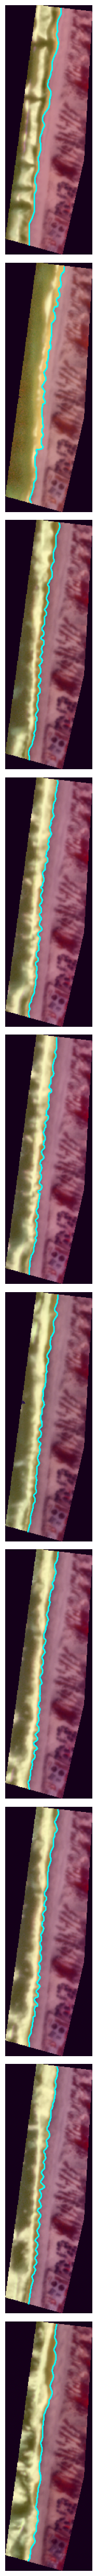

In [197]:
from skimage import exposure

TIF_PATHS = sorted(list(SKYSAT_PATH.glob("*pansharpened_clip.tif")))
LABEL_PATH = SKYSAT_LABEL_PATH # DOVE_LABEL_PATH

TIF_PATHS = sorted(list(DOVE_PATH.glob("*SR_8b_clip.tif")))
LABEL_PATH = DOVE_LABEL_PATH

mask = None
for pth in TIF_PATHS:
    with rasterio.open(pth) as src:
        mask0 = src.read(1, masked=True).mask
        if mask is None:
            mask = mask0
        mask &= mask0

rot_matrix, (new_w, new_h), angle = compute_rotation_matrix_for_mask(~mask)

dove_images = []
dove_labels = []
dove_nodata = []
dove_label_lines = []

cols = 1
rows = len(TIF_PATHS)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(2 * cols, 5 * rows))
for ax in axes.flatten():
    ax.axis('off')

for i, pth in enumerate(TIF_PATHS):
    with rasterio.open(pth) as src:
        nodata = src.read(1, masked=True).mask
        
    img = fc_img(pth)
    img = np.uint8(exposure.equalize_adapthist(img) * 255)
    img[nodata] = 0
    dove_images.append(img)
    dove_nodata.append(nodata)
    
    label = cv2.imread(str(LABEL_PATH / (pth.stem + ".png")))[:, :, 0]
    label[nodata] = 0
    dove_labels.append(label)
    
    boundary = extract_clean_water_boundary(label, nodata)
    dove_label_lines.append(boundary)
    
    axes[i].imshow(img)
    axes[i].imshow(label, alpha=0.3, interpolation='none')
    
    # Plot the boundary
    if boundary.geom_type == "LineString":
        xs, ys = boundary.xy
        axes[i].plot(xs, ys, color='cyan', linewidth=2)
    elif boundary.geom_type == "MultiLineString":
        for line in boundary.geoms:
            xs, ys = line.xy
            axes[i].plot(xs, ys, color='cyan', linewidth=2)
            
fig.tight_layout()

In [198]:
checkpoint = "BAAI/seggpt-vit-large"
image_processor = SegGptImageProcessor.from_pretrained(checkpoint)
model = SegGptForImageSegmentation.from_pretrained(checkpoint)

image_prompt = crop_image_sliding(dove_images[0])
mask_prompt = crop_image_sliding(dove_labels[0])

dove_pred_labels = []
dove_pred_lines = []

for r, (img, label, nodata) in enumerate(zip(
    tqdm.tqdm(dove_images[1:]), 
    dove_labels[1:], 
    dove_nodata[1:],
), start=1):

    image_inputs = crop_image_sliding(img)
    pred_label = np.zeros_like(label)
    
    for i, (((sh, eh), (sw, ew)), inpt) in enumerate(zip(crop_sliding_idx(img), image_inputs)):

        inputs = image_processor(
            images=inpt,
            prompt_images=image_prompt[i],
            prompt_masks=mask_prompt[i],
            num_labels=1,
            return_tensors="pt",
            data_format="channels_first",
        )
 
        with torch.no_grad():
            outputs = model(**inputs)

        target_sizes = [inpt.shape[:2], inpt.shape[:2]]
        pred_mask = image_processor.post_process_semantic_segmentation(outputs, target_sizes, num_labels=1)[0].numpy()
        pred_mask = pred_mask == 1
        if ew - sw > eh - sh:
            pred_label[sh:eh, sw:ew] |= pred_mask[:(eh - sh)]
        else:
            pred_label[sh:eh, sw:ew] |= pred_mask[:, :(ew - sw)]
        
    pred_label[nodata] = False
    pred_label = cv2.morphologyEx(pred_label.astype(np.uint8), cv2.MORPH_OPEN, np.ones((5, 5)))
    pred_label = cv2.morphologyEx(pred_label, cv2.MORPH_CLOSE, np.ones((5, 5))) == 1
    
    dove_pred_labels.append(pred_label)
    boundary = extract_clean_water_boundary(pred_label, nodata)
    dove_pred_lines.append(boundary)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:51<00:00, 12.35s/it]


In [194]:
from src.util.util import save_tif

# save_dir = Path("/Users/kyledorman/Desktop/Marina_dunes_psscene_analytic_8b_sr_udm2/predictions/")
save_dir = Path("/Users/kyledorman/Desktop/marina_skysat_skysatcollect_pansharpened_udm2/predictions/")
save_dir.mkdir(exist_ok=True, parents=True)

for pth, pred_label in zip(TIF_PATHS[1:], dove_pred_labels):
    with rasterio.open(pth) as src:
        meta = src.meta.copy()
        
    save_tif(save_dir / pth.name, np.uint8(pred_label == 1), meta, onebit=True)

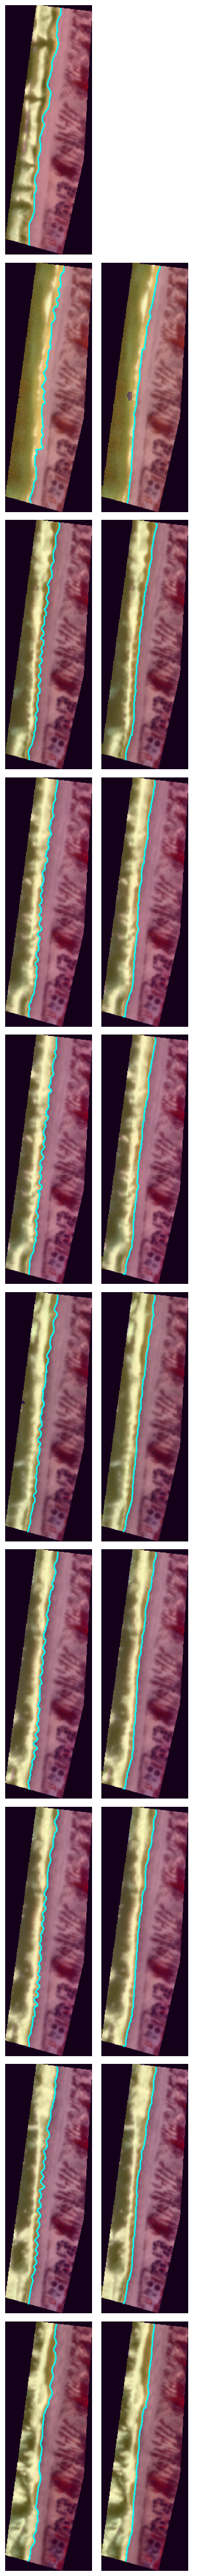

In [199]:
cols = 2
rows = len(dove_labels)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(2 * cols, 5 * rows))
for ax in axes.flatten():
    ax.axis('off')

axes[0, 0].imshow(dove_images[0])
axes[0, 0].imshow(dove_labels[0], alpha=0.3, interpolation='none')
# Plot the boundary
boundary = dove_label_lines[0]
if boundary.geom_type == "LineString":
    xs, ys = boundary.xy
    axes[0, 0].plot(xs, ys, color='cyan', linewidth=2)
elif boundary.geom_type == "MultiLineString":
    for line in boundary.geoms:
        xs, ys = line.xy
        axes[0, 0].plot(xs, ys, color='cyan', linewidth=2)

for r, (img, label, nodata, gt_boundary, pred_label, pred_line) in enumerate(zip(
    dove_images[1:], 
    dove_labels[1:], 
    dove_nodata[1:],
    dove_label_lines[1:],
    dove_pred_labels,
    dove_pred_lines,
), start=1):
    
    axes[r, 0].imshow(img)
    axes[r, 0].imshow(label, alpha=0.3, interpolation='none')
    if gt_boundary.geom_type == "LineString":
        xs, ys = gt_boundary.xy
        axes[r, 0].plot(xs, ys, color='cyan', linewidth=2)
    elif gt_boundary.geom_type == "MultiLineString":
        for line in gt_boundary.geoms:
            xs, ys = line.xy
            axes[r, 0].plot(xs, ys, color='cyan', linewidth=2)
    
    axes[r, 1].imshow(img)
    
    axes[r, 1].imshow(pred_label, alpha=0.3, interpolation='none')
    
    if pred_line.geom_type == "LineString":
        xs, ys = pred_line.xy
        axes[r, 1].plot(xs, ys, color='cyan', linewidth=2)
    elif pred_line.geom_type == "MultiLineString":
        for line in pred_line.geoms:
            xs, ys = line.xy
            axes[r, 1].plot(xs, ys, color='cyan', linewidth=2)
    
fig.tight_layout()

In [196]:
from shapely.geometry import LineString
from shapely.ops import nearest_points

def average_symmetric_distance(line_pred, line_label, num_samples=1000):
    """
    Compute average symmetric distance (ASD) between two LineStrings.

    Args:
        line_pred (LineString or MultiLineString): predicted boundary line
        line_label (LineString or MultiLineString): ground truth boundary line
        num_samples (int): number of sample points along each line

    Returns:
        float: Average symmetric distance in pixels
    """
    def sample_points(line, num):
        dists = np.linspace(0, line.length, num=num)
        return [line.interpolate(d) for d in dists]

    # Merge MultiLineStrings if needed
    if line_pred.geom_type == "MultiLineString":
        return -1
        line_pred = LineString([pt for l in line_pred for pt in l.coords])
    if line_label.geom_type == "MultiLineString":
        line_label = LineString([pt for l in line_label for pt in l.coords])

    pred_pts = sample_points(line_pred, num_samples)
    label_pts = sample_points(line_label, num_samples)

    # One-directional distance: predicted → label
    d_pred_to_label = [p.distance(line_label) for p in pred_pts]
    d_label_to_pred = [p.distance(line_pred) for p in label_pts]

    return (np.mean(d_pred_to_label) + np.mean(d_label_to_pred)) / 2.0

from shapely.ops import unary_union
from shapely.geometry import MultiPoint

def hausdorff_distance(line_pred, line_label):
    return line_pred.hausdorff_distance(line_label)

for label, pred in zip(dove_label_lines[1:], dove_pred_lines):
    print(average_symmetric_distance(pred, label), hausdorff_distance(pred, label))

5.910002687843898 77.46612162745726
-1 407.23764560757394
11.251031344500802 109.41663493271945
9.044326054003708 92.69843580125827
14.288608995968154 97.74456506629922
10.78721285892873 106.73331251301067
9.950630699679303 96.6902270139025


In [ ]:
import rasterio
from rasterio.features import shapes
import numpy as np
from shapely.geometry import shape
from shapely.ops import unary_union
from shapely.affinity import rotate
from shapely.geometry import Polygon
import geopandas as gpd

def mask_to_rotated_boxes(geotiff_path):
    with rasterio.open(geotiff_path) as src:
        mask = ~src.read(1, masked=True).mask  # Read first band
        transform = src.transform

        # Extract shapes (polygons) from the binary mask
        results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for s, v in shapes(mask.astype(np.uint8), transform=transform)
        )

        polygons = [shape(feature["geometry"]) for feature in results]

    # Merge all shapes together (if needed)
    merged = unary_union(polygons)

    # Handle MultiPolygon or single Polygon
    if merged.geom_type == 'Polygon':
        geoms = [merged]
    else:
        geoms = list(merged.geoms)

    # Compute minimum rotated rectangles
    rotated_boxes = [geom.minimum_rotated_rectangle for geom in geoms]

    # Optional: convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=rotated_boxes, crs=src.crs)

    return gdf

gdf = mask_to_rotated_boxes(skysat_paths[0]).to_crs(epsg=4326)

gdf.to_file("/Users/kyledorman/Desktop/marina.geojson", driver="GeoJSON")